In [1]:
import pandas as pd
import numpy as np
from pydataset import data
import os
import env
import acquire as a
import prepare as p
import wrangle as w

#Stats imports
from scipy import stats
from scipy.stats import pearsonr, spearmanr

#visual imports
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#sklearn split, impute, math stuff
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score

# Scalers
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# modeling methods
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression


import warnings
warnings.filterwarnings("ignore")

## Select a dataset with a continuous target variable.

In [2]:
df = w.wrangle_zillow()
df.head(3)

,bedrooms,bathrooms,sq_ft,tax_value,year,tax_amount,fips,tax_rate
0,2.0,1.0,1412.0,222671.0,1947.0,2954.03,6037.0,1.326634
1,3.0,2.0,1296.0,64968.0,1955.0,909.28,6037.0,1.399581
2,3.0,1.0,1044.0,126800.0,1947.0,1767.69,6037.0,1.394077


## Be sure your data is prepared (no missing values, numeric datatypes) and split into samples.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55725 entries, 0 to 56078
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   bedrooms    55725 non-null  float64
 1   bathrooms   55725 non-null  float64
 2   sq_ft       55725 non-null  float64
 3   tax_value   55725 non-null  float64
 4   year        55725 non-null  float64
 5   tax_amount  55725 non-null  float64
 6   fips        55725 non-null  float64
 7   tax_rate    55725 non-null  float64
dtypes: float64(8)
memory usage: 3.8 MB


In [4]:
df.isna().sum()

bedrooms      0
bathrooms     0
sq_ft         0
tax_value     0
year          0
tax_amount    0
fips          0
tax_rate      0
dtype: int64

In [5]:
df[['sq_ft']].quantile(.99)

sq_ft    5272.76
Name: 0.99, dtype: float64

In [6]:
df[df['sq_ft'] > 5263]

,bedrooms,bathrooms,sq_ft,tax_value,year,tax_amount,fips,tax_rate
320,5.0,5.0,5889.0,1776686.0,1987.0,19718.30,6037.0,1.109836
384,5.0,8.0,7711.0,4390833.0,1936.0,52907.33,6037.0,1.204950
427,3.0,4.0,5374.0,715938.0,1992.0,8928.39,6037.0,1.247090
563,5.0,6.0,5542.0,2884344.0,1987.0,34861.44,6037.0,1.208644
573,4.0,4.0,5579.0,2114051.0,1989.0,25512.79,6037.0,1.206820
...,...,...,...,...,...,...,...,...
54969,5.0,5.5,5742.0,1429895.0,1998.0,14771.56,6059.0,1.033052
55027,4.0,4.5,5432.0,1389287.0,1988.0,14261.52,6059.0,1.026535
55054,5.0,4.5,6227.0,1340882.0,1984.0,13834.88,6059.0,1.031775
55514,8.0,6.0,7182.0,1421000.0,1984.0,17443.19,6037.0,1.227529


In [7]:
# Going to drop two highest sq_ft houses
df.sort_values('sq_ft', ascending=False).head()

,bedrooms,bathrooms,sq_ft,tax_value,year,tax_amount,fips,tax_rate
29909,10.0,19.5,26345.0,11689668.0,1981.0,369.08,6059.0,0.003157
24560,8.0,1.5,20433.0,5310449.0,1997.0,56058.04,6111.0,1.055618
44782,9.0,10.0,19346.0,4151368.0,1995.0,45888.56,6059.0,1.105384
12449,5.0,13.0,19335.0,10904781.0,1997.0,131646.20,6037.0,1.207234
42869,5.0,8.0,16853.0,9841049.0,2012.0,118222.35,6037.0,1.201319


In [8]:
bins = df['sq_ft'].quantile([0 ,.1,.2,.3,.4,.5,.6,.7,.8,.9, 1])

(array([5548., 5539., 5614., 5576., 5543., 5592., 5588., 5571., 5575.,
        5579.]),
 array([2.0000e+01, 1.0280e+03, 1.1960e+03, 1.3320e+03, 1.4760e+03,
        1.6300e+03, 1.8180e+03, 2.0620e+03, 2.3980e+03, 2.9520e+03,
        2.6345e+04]),
 [<matplotlib.patches.Polygon at 0x14be312b0>])

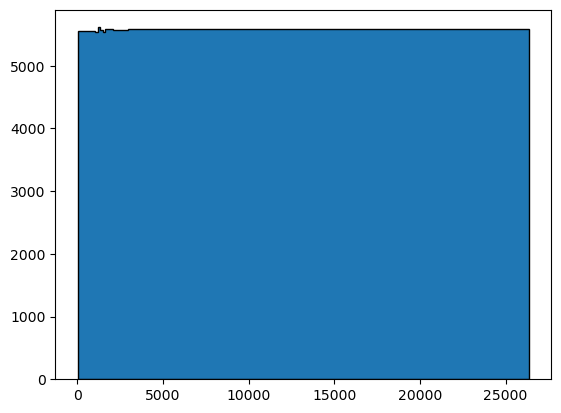

In [9]:
plt.hist(df.sq_ft, bins=bins, ec='black', histtype='stepfilled')

In [10]:
# index list of homes over 5263 sq_ft. Top 1% being dropped. 562 dropped
index_sqft = df[df['sq_ft'] > 5263].index.tolist()
len(index_sqft)

562

In [11]:
# Dropping homes over 5263 sqft. 
df.drop(index=index_sqft, inplace=True)

In [12]:
# Index list of all homes with no bathrooms. Should be 123 observations.
index_bath = df[df['bathrooms'] == 0].index.tolist()
len(index_bath)

123

In [13]:
# Dropping all instances where bathrooms == 0.
df.drop(index=index_bath, inplace=True)

In [14]:
# Index list of all homes with no bedrooms. 20 observations
index_beds = df[df['bedrooms'] < 1].index.tolist()
len(index_beds)

20

In [15]:
# Drop houses with no bedrooms
df.drop(index=index_beds, inplace=True)

In [16]:
# Dropping these columns. Too correlated to tax_value
df.drop(['tax_amount', 'tax_rate'], axis=1, inplace=True)

In [17]:
df.head(3)

,bedrooms,bathrooms,sq_ft,tax_value,year,fips
0,2.0,1.0,1412.0,222671.0,1947.0,6037.0
1,3.0,2.0,1296.0,64968.0,1955.0,6037.0
2,3.0,1.0,1044.0,126800.0,1947.0,6037.0


In [18]:
# creating dummies for fips
df = pd.get_dummies(df, columns=['fips'])

In [19]:
df.head()

,bedrooms,bathrooms,sq_ft,tax_value,year,fips_6037.0,fips_6059.0,fips_6111.0
0,2.0,1.0,1412.0,222671.0,1947.0,1,0,0
1,3.0,2.0,1296.0,64968.0,1955.0,1,0,0
2,3.0,1.0,1044.0,126800.0,1947.0,1,0,0
3,3.0,2.0,1336.0,213833.0,1955.0,1,0,0
4,3.0,2.0,1510.0,338022.0,1979.0,1,0,0


In [20]:
# Train, Validate, Test
train, val, test = p.split_data_continious(df)
train.shape, val.shape, test.shape

((30811, 8), (13205, 8), (11004, 8))

## Work through all of the steps outlined in the lesson, from setting the baseline to selected a model and evaluating the final model on your test data.

### Baseline

In [21]:
train.head(3)

,bedrooms,bathrooms,sq_ft,tax_value,year,fips_6037.0,fips_6059.0,fips_6111.0
25743,3.0,2.0,1396.0,365489.0,1931.0,1,0,0
15681,2.0,2.0,955.0,242094.0,1938.0,1,0,0
25495,3.0,2.0,1539.0,255632.0,1941.0,1,0,0


In [22]:
# deep copy of train dataset to maintain integrity of original df
train_cp = train.copy()

In [23]:
# Scaler Object
minmax = MinMaxScaler()

In [24]:
# Scaling Columns, except fips
train_cp[['bedrooms','bathrooms','sq_ft','year']] =\
minmax.fit_transform(train_cp[['bedrooms','bathrooms','sq_ft','year']])

In [25]:
train_cp.head()

,bedrooms,bathrooms,sq_ft,tax_value,year,fips_6037.0,fips_6059.0,fips_6111.0
25743,0.2,0.166667,0.217770,365489.0,0.448052,1,0,0
15681,0.1,0.166667,0.128516,242094.0,0.493506,1,0,0
25495,0.2,0.166667,0.246711,255632.0,0.512987,1,0,0
38339,0.2,0.166667,0.272819,244943.0,0.597403,1,0,0
27994,0.3,0.333333,0.593605,521873.0,0.805195,1,0,0


In [26]:
# The trains
X_train = train_cp.drop(['tax_value'], axis=1)
y_train = train_cp['tax_value']

X_val = val.drop(['tax_value'], axis=1)
y_val = val['tax_value']

X_test = test.drop(['tax_value'], axis=1)
y_test = test['tax_value']

In [27]:
# Baseline = Mean Tax Value
train_cp['baseline'] = train_cp['tax_value'].mean()
train_cp.head(3)

,bedrooms,bathrooms,sq_ft,tax_value,year,fips_6037.0,fips_6059.0,fips_6111.0,baseline
25743,0.2,0.166667,0.217770,365489.0,0.448052,1,0,0,426682.254747
15681,0.1,0.166667,0.128516,242094.0,0.493506,1,0,0,426682.254747
25495,0.2,0.166667,0.246711,255632.0,0.512987,1,0,0,426682.254747


### OLS Linear Regression

In [28]:
# Model Object for predictions
lm = LinearRegression()

In [29]:
# Fit model
lm.fit(X_train, y_train)

LinearRegression()

In [30]:
# Predictions
train_cp['lm_preds'] = lm.predict(X_train)
train_cp.head(3)

,bedrooms,bathrooms,sq_ft,tax_value,year,fips_6037.0,fips_6059.0,fips_6111.0,baseline,lm_preds
25743,0.2,0.166667,0.217770,365489.0,0.448052,1,0,0,426682.254747,347520.0
15681,0.1,0.166667,0.128516,242094.0,0.493506,1,0,0,426682.254747,288128.0
25495,0.2,0.166667,0.246711,255632.0,0.512987,1,0,0,426682.254747,374784.0


In [31]:
import evaluate as e

In [32]:
# Basline performance
bs_perf = e.baseline_mean_errors(y_train)
bs_perf


        Baseline Mean Errors
        --------------------
        SSE: 5932177623794784.0
        MSE: 192534407315.3998
        RMSE: 438787.42839260993
    


(5932177623794784.0, 192534407315.3998, 438787.42839260993)

In [33]:
# Model Performance
lm_perf = e.regression_errors(y_train, train_cp.lm_preds)
lm_perf


        Regression Errors
        -----------------
        SSE: 3859672233881231.0
        MSE: 125269294533.81036
        RMSE: 353934.0256796602
        ESS: 2074067730516664.8
        TSS: 5933739964397896.0
    


(125269294533.81036,
 353934.0256796602,
 3859672233881231.0,
 2074067730516664.8,
 5933739964397896.0)

In [34]:
e.better_than_baseline(y_train, train_cp.lm_preds)


        Regression Errors
        -----------------
        SSE: 3859672233881231.0
        MSE: 125269294533.81036
        RMSE: 353934.0256796602
        ESS: 2074067730516664.8
        TSS: 5933739964397896.0
    

        Baseline Mean Errors
        --------------------
        SSE: 5932177623794784.0
        MSE: 192534407315.3998
        RMSE: 438787.42839260993
    
Model is better


### LassoLars

In [35]:
lars = LassoLars(alpha=.3)

In [36]:
lars.fit(X_train, y_train)

LassoLars(alpha=0.3)

In [37]:
train_cp['lars_preds'] = lars.predict(X_train)
train_cp.head()

,bedrooms,bathrooms,sq_ft,tax_value,year,fips_6037.0,fips_6059.0,fips_6111.0,baseline,lm_preds,lars_preds
25743,0.2,0.166667,0.217770,365489.0,0.448052,1,0,0,426682.254747,347520.0,347347.393502
15681,0.1,0.166667,0.128516,242094.0,0.493506,1,0,0,426682.254747,288128.0,287211.756243
25495,0.2,0.166667,0.246711,255632.0,0.512987,1,0,0,426682.254747,374784.0,374616.889524
38339,0.2,0.166667,0.272819,244943.0,0.597403,1,0,0,426682.254747,392320.0,392207.414684
27994,0.3,0.333333,0.593605,521873.0,0.805195,1,0,0,426682.254747,834816.0,834769.323087


In [38]:
lars_bs_errors = e.baseline_mean_errors(y_train)
lars_bs_errors


        Baseline Mean Errors
        --------------------
        SSE: 5932177623794784.0
        MSE: 192534407315.3998
        RMSE: 438787.42839260993
    


(5932177623794784.0, 192534407315.3998, 438787.42839260993)

In [39]:
lars_reg_errors = e.regression_errors(y_train, train_cp.lars_preds)
lars_reg_errors


        Regression Errors
        -----------------
        SSE: 3859661198506733.0
        MSE: 125268936370.34608
        RMSE: 353933.51970440167
        ESS: 2070992507355090.0
        TSS: 5930653705861823.0
    


(125268936370.34608,
 353933.51970440167,
 3859661198506733.0,
 2070992507355090.0,
 5930653705861823.0)

In [40]:
e.better_than_baseline(y_train, train_cp.lars_preds)


        Regression Errors
        -----------------
        SSE: 3859661198506733.0
        MSE: 125268936370.34608
        RMSE: 353933.51970440167
        ESS: 2070992507355090.0
        TSS: 5930653705861823.0
    

        Baseline Mean Errors
        --------------------
        SSE: 5932177623794784.0
        MSE: 192534407315.3998
        RMSE: 438787.42839260993
    
Model is better


### TweedieRegressor Generalized Linear Model

(0.0, 1000000.0)

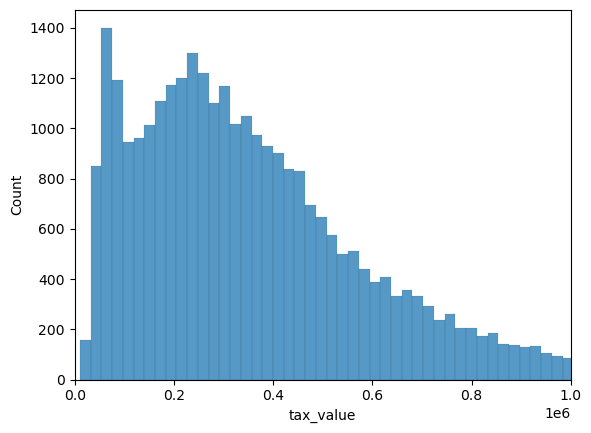

In [41]:
sns.histplot(train_cp.tax_value)
plt.xlim(0, 1000000)

In [42]:
glm = TweedieRegressor(power=0, alpha=1)

In [43]:
glm.fit(X_train, y_train)

TweedieRegressor(alpha=1, power=0)

In [44]:
# GLM Predictions
train_cp['glm_preds'] = glm.predict(X_train)

In [45]:
train_cp.head()

,bedrooms,bathrooms,sq_ft,tax_value,year,fips_6037.0,fips_6059.0,fips_6111.0,baseline,lm_preds,lars_preds,glm_preds
25743,0.2,0.166667,0.217770,365489.0,0.448052,1,0,0,426682.254747,347520.0,347347.393502,412706.102724
15681,0.1,0.166667,0.128516,242094.0,0.493506,1,0,0,426682.254747,288128.0,287211.756243,409025.408641
25495,0.2,0.166667,0.246711,255632.0,0.512987,1,0,0,426682.254747,374784.0,374616.889524,414587.110512
38339,0.2,0.166667,0.272819,244943.0,0.597403,1,0,0,426682.254747,392320.0,392207.414684,416602.086440
27994,0.3,0.333333,0.593605,521873.0,0.805195,1,0,0,426682.254747,834816.0,834769.323087,437223.165265


In [46]:
e.better_than_baseline(y_train, train_cp.glm_preds)


        Regression Errors
        -----------------
        SSE: 5744408906294160.0
        MSE: 186440196887.2857
        RMSE: 431787.21251015033
        ESS: 9203723212320.95
        TSS: 5753612629506481.0
    

        Baseline Mean Errors
        --------------------
        SSE: 5932177623794784.0
        MSE: 192534407315.3998
        RMSE: 438787.42839260993
    
Model is better


### Polynomial Regression

In [47]:
pf = PolynomialFeatures(degree=2)

In [48]:
pf.fit(X_train, y_train)

PolynomialFeatures()

In [49]:
X_train_degree2 = pf.fit_transform(X_train)

In [50]:
lm2 = LinearRegression(normalize=True)

In [51]:
lm2.fit(X_train_degree2, y_train)

LinearRegression(normalize=True)

In [52]:
train_cp['pf_preds'] = lm2.predict(X_train_degree2)

In [53]:
e.better_than_baseline(y_train, train_cp.pf_preds)


        Regression Errors
        -----------------
        SSE: 3597246361399823.0
        MSE: 116752015883.93181
        RMSE: 341689.9411512312
        ESS: 2341386819614757.5
        TSS: 5938633181014580.0
    

        Baseline Mean Errors
        --------------------
        SSE: 5932177623794784.0
        MSE: 192534407315.3998
        RMSE: 438787.42839260993
    
Model is better


In [54]:
df

,bedrooms,bathrooms,sq_ft,tax_value,year,fips_6037.0,fips_6059.0,fips_6111.0
0,2.0,1.0,1412.0,222671.0,1947.0,1,0,0
1,3.0,2.0,1296.0,64968.0,1955.0,1,0,0
2,3.0,1.0,1044.0,126800.0,1947.0,1,0,0
3,3.0,2.0,1336.0,213833.0,1955.0,1,0,0
4,3.0,2.0,1510.0,338022.0,1979.0,1,0,0
...,...,...,...,...,...,...,...,...
56074,3.0,2.0,2068.0,134592.0,1960.0,1,0,0
56075,3.0,2.0,1872.0,703466.0,1930.0,1,0,0
56076,2.0,2.0,1327.0,301499.0,1951.0,1,0,0
56077,3.0,2.0,2168.0,858901.0,1952.0,1,0,0
